In [7]:
import numpy as np
np.set_printoptions(threshold=np.nan)

import pandas as pd
import sys

sys.path.append('python')
from clusterOutliers import clusterOutliers as coo

In [5]:
def make_sampler(inds=['8462852']): 
    """
    Args:
        inds (Array of strings) - array of indices, as identifying strings, to be pulled from a data frame, 
                                  can be with or without kplr prefix
    Returns:
        Function that will pull the data, indicated by inds, from a dataframe df 
        
    Useful to generate samples across quarters with common sources where data is contained as a 
    Pandas dataframe, with indices set to be identifying labels (i.e. kplr008462852)
    
    To use:
        Define array containing IDs of sources of interest as strings
        Define a sample generator by calling make_sampler(inds=Array of string IDs)
        Generate dataframe by calling new function.

    Example:
    tabby_sample = make_sampler(inds=['8462852'])
    Q4_sample = tabby_sample(Q4.data)
    Q8_sample = tabby_sample(Q8.data)
    etc.
    """
    return lambda df: df[df.index.str.contains('|'.join(inds))]

def import_generator(suffix='_FullSample.csv',
                     filepath="/home/dgiles/Documents/KeplerLCs/output/",
                    fits_files_directory="/home/dgiles/Documents/KeplerLCs/fitsFiles/"):
    """
    Args:
        suffix (str) - the suffix of the file to be imported
        filepath (optional, str) - filepath to the file to be imported
        fits_files_directory (optional, str) - path to the directory containing the fits files
        
    Returns:
        lambda function that with single str input of the prefix, typically a Q#.
    
    Use:
        Enables simpler import of multiple quarters of data contained 
        in the same location with the same suffixes.
    
    Requirements: 
    import sys
    sys.path.append('python')
    from clusterOutliers import clusterOutliers as coo
    """
    return lambda QN: coo(filepath+QN+suffix,fits_files_directory+QN+"fitsfiles")

In [102]:
import_quarter = import_generator(suffix="_FullSample.csv")
qs = ['Q4','Q8','Q11','Q16']
paper_qs = dict(zip(qs,[import_quarter(Q) for Q in qs]))
#Q4p = import_quarter('Q4')

In [460]:
PCA_folder = "/home/dgiles/Documents/KeplerLCs/output/PCA_reductions/"
import_base = import_generator(suffix="_base", filepath=PCA_folder)
base_qs = dict(zip(qs,[import_base(Q) for Q in qs]))

In [82]:
def catalog_sample(source,full_q_df,print_summary=True):
    
    catalog_list = list(np.genfromtxt(source,delimiter=',',dtype=str)[:,0])
    catalog_sampler = make_sampler(catalog_list)
    catalog_df = catalog_sampler(full_q_df)
    outliers = lambda df: df[df.db_out==-1]
    catalog_outliers = outliers(catalog_df)
    q_outliers = outliers(full_q_df)
    
    if print_summary:
        print("""
The {} objects in the catalog comprise {:.2f}% of the {} objects in the quarter.
{} ({:.2f}%) of the catalog objects are outliers, comprising ({:.2f}%) of the {} total outliers in this quarter.
""".format(len(catalog_df), 100*len(catalog_df)/len(full_q_df), len(full_q_df),
           len(catalog_outliers), 100*len(catalog_outliers)/len(catalog_df),
           100*len(catalog_outliers)/len(q_outliers),len(q_outliers)
          ))
            
    return catalog_df
              
kois_full = catalog_sample('list_koi_full.txt',Q4p.data)


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1243 (18.13%) of the catalog objects are outliers, comprising (25.54%) of the 4866 total outliers in this quarter.



In [85]:
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Q4p.data)


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
94 (6.72%) of the catalog objects are outliers, comprising (1.93%) of the 4866 total outliers in this quarter.



In [86]:
kois_candidate = catalog_sample('list_koi_candidate.txt',Q4p.data)


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
85 (4.82%) of the catalog objects are outliers, comprising (1.75%) of the 4866 total outliers in this quarter.



In [87]:
kois_fp = catalog_sample('list_koi_fp.txt',Q4p.data)


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1080 (27.00%) of the catalog objects are outliers, comprising (22.19%) of the 4866 total outliers in this quarter.



In [89]:
ebs = catalog_sample('list_EBs.csv',Q4p.data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1673 (76.50%) of the catalog objects are outliers, comprising (34.38%) of the 4866 total outliers in this quarter.



In [111]:
outliers = lambda df: df[df.db_out==-1]

summary_df = pd.DataFrame({
    "ctlg_ct":[len(ebs),len(kois_full),len(kois_confirmed),len(kois_candidate),len(kois_fp)],
    "ctlg_U_Q4out":[len(outliers(ebs)),
                    len(outliers(kois_full)),
                    len(outliers(kois_confirmed)),
                    len(outliers(kois_candidate)),
                    len(outliers(kois_fp))
                   ],
},
    index=["Eclipsing Binaries","KOIs","KOIs Confirmed","KOI Candidates","KOIs False Positive"]
)
summary_df = summary_df[["ctlg_ct","ctlg_U_Q4out"]] # ensuring proper order
summary_df

,ctlg_ct,ctlg_U_Q4out
Eclipsing Binaries,2187,1652
KOIs,6856,1243
KOIs Confirmed,1399,94
KOI Candidates,1765,85
KOIs False Positive,4000,1080


In [103]:
ebs = catalog_sample('list_EBs.csv',paper_qs['Q8'].data)


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.



In [112]:
Q='Q8'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1652 (75.54%) of the catalog objects are outliers, comprising (32.75%) of the 5044 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1216 (17.74%) of the catalog objects are outliers, comprising (24.11%) of the 5044 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
86 (6.15%) of the catalog objects are outliers, comprising (1.70%) of the 5044 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
89 (5.04%) of the catalog objects are outliers, comprising (1.76%) of the 5044 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1059 (26.48%) of the catalog objects are outliers, comprising (21.00%) of the 5044 total outliers in this quarter.

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out
Eclipsing Binaries,2187,1652,1652
KOIs,6856,1243,1216
KOIs Confirmed,1399,94,86
KOI Candidates,1765,85,89
KOIs False Positive,4000,1080,1059


In [113]:
Q='Q11'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1731 (79.15%) of the catalog objects are outliers, comprising (29.44%) of the 5879 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1338 (19.52%) of the catalog objects are outliers, comprising (22.76%) of the 5879 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
106 (7.58%) of the catalog objects are outliers, comprising (1.80%) of the 5879 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
101 (5.72%) of the catalog objects are outliers, comprising (1.72%) of the 5879 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1147 (28.68%) of the catalog objects are outliers, comprising (19.51%) of the 5879 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out
Eclipsing Binaries,2187,1652,1652,1731
KOIs,6856,1243,1216,1338
KOIs Confirmed,1399,94,86,106
KOI Candidates,1765,85,89,101
KOIs False Positive,4000,1080,1059,1147


In [114]:
Q='Q16'
Qdf = paper_qs[Q].data
ebs = catalog_sample('list_EBs.csv',Qdf)
kois_full = catalog_sample('list_koi_full.txt',Qdf)
kois_confirmed = catalog_sample('list_koi_confirmed.txt',Qdf)
kois_candidate = catalog_sample('list_koi_candidate.txt',Qdf)
kois_fp = catalog_sample('list_koi_fp.txt',Qdf)

summary_df["ctlg_U_"+Q+"out"]=[len(outliers(ebs)),
                               len(outliers(kois_full)),
                               len(outliers(kois_confirmed)),
                               len(outliers(kois_candidate)),
                               len(outliers(kois_fp))]
summary_df


The 2187 objects in the catalog comprise 1.46% of the 149789 objects in the quarter.
1724 (78.83%) of the catalog objects are outliers, comprising (29.98%) of the 5750 total outliers in this quarter.


The 6856 objects in the catalog comprise 4.58% of the 149789 objects in the quarter.
1362 (19.87%) of the catalog objects are outliers, comprising (23.69%) of the 5750 total outliers in this quarter.


The 1399 objects in the catalog comprise 0.93% of the 149789 objects in the quarter.
111 (7.93%) of the catalog objects are outliers, comprising (1.93%) of the 5750 total outliers in this quarter.


The 1765 objects in the catalog comprise 1.18% of the 149789 objects in the quarter.
102 (5.78%) of the catalog objects are outliers, comprising (1.77%) of the 5750 total outliers in this quarter.


The 4000 objects in the catalog comprise 2.67% of the 149789 objects in the quarter.
1167 (29.18%) of the catalog objects are outliers, comprising (20.30%) of the 5750 total outliers in this quarte

,ctlg_ct,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_U_Q11out,ctlg_U_Q16out
Eclipsing Binaries,2187,1652,1652,1731,1724
KOIs,6856,1243,1216,1338,1362
KOIs Confirmed,1399,94,86,106,111
KOI Candidates,1765,85,89,101,102
KOIs False Positive,4000,1080,1059,1147,1167


In [150]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict


with open('kepler_solar_flares.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[22:]] 

solar_flares = catalog_summary(catalog_list,paper_qs)

df_tmp = pd.DataFrame(solar_flares,index=['Solar Flares'])
summary_df = summary_df.append(df_tmp)
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041


In [200]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adict

In [201]:
with open('list_kepler_nosig.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[28:]] 

no_sig = catalog_summary(catalog_list,paper_qs)
no_sig

{'ctlg_U_Q11out': 429,
 'ctlg_U_Q16out': 388,
 'ctlg_U_Q4out': 324,
 'ctlg_U_Q8out': 329,
 'ctlg_ct': 99000}

In [202]:
df_tmp = pd.DataFrame(no_sig,index=['Main Sequence, No Periodicity'])
summary_df = summary_df.append(df_tmp)
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000


In [203]:
with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[32:]] 

MS_periodic = catalog_summary(catalog_list,paper_qs)
MS_periodic

{'ctlg_U_Q11out': 1658,
 'ctlg_U_Q16out': 1602,
 'ctlg_U_Q4out': 1297,
 'ctlg_U_Q8out': 1395,
 'ctlg_ct': 34030}

In [204]:
df_tmp = pd.DataFrame(MS_periodic,index=['Main Sequence, With Periodicity'])
summary_df = summary_df.append(df_tmp)
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000
"Main Sequence, With Periodicity",1658,1602,1297,1395,34030


|List| Source| Bibcode (if single source)|
|----|-------|---------------------------|
|Eclipsing Binaries| EB list| one exists|
|KOIs|Mikulski AST| don't know if there's one bibcode|
|KOIs Confirmed| Mikulski| needs cited|
|KOI Candidates| Mikulski| needs cited|
|KOI False Positives| Mikulski| needs cited|
|Solar Flares| paper| needs cited|
|MS, no periodicity| paper| needs cited|
|MS, w/ periodicity| paper| needs cited|



In [412]:
with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
lines[208:-2]

['11970288\n', '12255108\n', '\n']

In [413]:
with open('list_kepler_heartbeats.txt','r') as file:
    lines = file.readlines()
catalog_list = [str(int(line[:8])) for line in lines[37:-2]] 

heartbeats = catalog_summary(catalog_list,paper_qs)
heartbeats

{'ctlg_U_Q11out': 49,
 'ctlg_U_Q16out': 39,
 'ctlg_U_Q4out': 35,
 'ctlg_U_Q8out': 40,
 'ctlg_ct': 173}

In [418]:
df_tmp = pd.DataFrame(heartbeats,index=['Heartbeat Stars'])
summary_df = summary_df.append(df_tmp)
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000
"Main Sequence, With Periodicity",1658,1602,1297,1395,34030
Heartbeat Stars,49,39,35,40,173


In [426]:
summary_df

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Eclipsing Binaries,1731,1724,1652,1652,2187
Heartbeat Stars,49,39,35,40,173
KOIs,1338,1362,1243,1216,6856
KOIs Confirmed,106,111,94,86,1399
KOI Candidates,101,102,85,89,1765
KOIs False Positive,1147,1167,1080,1059,4000
Solar Flares,1368,1388,1264,1276,4041
"Main Sequence, No Periodicity",429,388,324,329,99000
"Main Sequence, With Periodicity",1658,1602,1297,1395,34030


In [137]:
with open('list_kepler_MSperiods.txt','r') as file:
    lines = file.readlines()

In [169]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

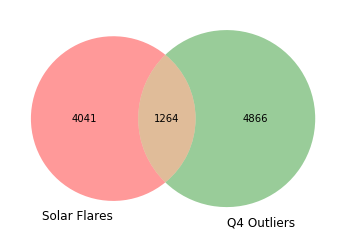

In [179]:
Q = 'Q4'
cat = 5
venn2(subsets = (summary_df.ctlg_ct[cat],len(outliers(paper_qs[Q].data)),summary_df['ctlg_U_'+Q+'out'][cat]),
      set_labels=(summary_df.index[cat],Q+' Outliers'))

In [242]:
with open('kepler_variable_classes.txt','r') as file:
    lines = file.readlines()

In [249]:
tmp = np.genfromtxt('kepler_variable_classes.txt',dtype=str,skip_header=50)

In [269]:
tmp[tmp[:,4]=='SR'][:,0]

array(['7451258', '12216195', '4588755', '11129407'], 
      dtype='<U8')

In [267]:
for cl in np.unique(tmp[:,4]):
    print("{}: {}".format(cl,len(tmp[tmp[:,4]==cl])))

ACT: 20862
BCEP: 19187
CLCEP: 21
DSCUT: 1060
ECL: 2544
ELL: 200
GDOR: 488
MISC: 96745
ROT: 8654
RRAB: 6
RRC: 16
RVTAU: 3
SPB: 466
SR: 4


In [271]:
def catalog_summary(catalog_list,qs_dict):
    """
    Args:
        catalog_list (list) - a list of the KICs in the catalog as strings. May have KIC, kplr, or no prefix.
        qs_dict (dictionary) - a dictionary containing different quarters as clusterOutlier objects. 
                                qs_dict[key].data must be a pandas dataframe
    
    Returns:
        adict (dict) - a dictionary containing summary numbers for the catalog
            ctlg_ct - the size of the catalog
            ctlg_U_*out - size of the union between the catalog and the quarter's outliers 
    """
    outliers = lambda df: df[df.db_out==-1]

    adict = {"ctlg_ct":len(catalog_list)}
    catalog_sampler = make_sampler(catalog_list)
    for q in qs_dict:
        catalog_df = catalog_sampler(qs_dict[q].data)
        catalog_outliers = outliers(catalog_df)
        adict["ctlg_U_"+q+"out"]=len(catalog_outliers)
    return adictctlg_U_Q16out

Debosscher_summary = pd.DataFrame()

for cl in np.unique(tmp[:,4]):
    if cl != 'MISC':
        catalog_list = tmp[tmp[:,4]==cl][:,0]
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        Debosscher_summary = Debosscher_summary.append(df_tmp)
    

In [382]:
cl='MISC'
catalog_list = tmp[tmp[:,4]==cl][:,0]
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=[cl])
Debosscher_summary = Debosscher_summary.append(df_tmp)

In [383]:
Debosscher_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
ACT,448,416,268,314,20862
BCEP,181,181,149,153,19187
CLCEP,18,17,18,18,21
DSCUT,150,160,108,104,1060
ECL,1136,1125,1081,1077,2544
ELL,126,118,116,116,200
GDOR,123,122,104,98,488
ROT,1413,1375,1153,1230,8654
RRAB,4,4,4,4,6
RRC,14,14,14,14,16


|Stellar variability class| 	Abbreviation| Count in Debosscher (in common w/ previous paper)*|
|-------------------------|-----------------|--------------------------------------------------|
|β-Cephei stars| 	BCEP| 19,187
|Classical Cepheids |	CLCEP| 21
|Double-mode Cepheids| 	DMCEP| 0
|δ-Scuti stars| 	DSCUT| 1060
|Eclipsing binaries (all types)| 	ECL| 2544
|Ellipsoidal variables| 	ELL| 200
|γ-Doradus stars| 	GDOR| 488
|Mira variables| 	MIRA| 0
|RR-Lyrae stars, subtype ab| 	RRAB| 6
|RR-Lyrae stars, subtype c| 	RRC| 16
|Double-mode RR-Lyrae stars| 	RRD| 0
|RV-Tauri stars| 	RVTAU| 3
|Slowly pulsating B-stars| 	SPB| 466
|Semi-regular variables| 	SR| 4
|Rotational modulation| 	ROT| 8654
|Active stars| 	ACT| 20862
|Miscellaneous| 	MISC| 96745

*Debosscher reports the probability for the top 3 classes for each object. The count here is based on primary identification regardless of its probability of belonging to that group.

|Class|ctlg_U_Q11out|ctlg_U_Q16out|ctlg_U_Q4out|ctlg_U_Q8out|ctlg_ct|
|-----|-------------|-------------|------------|------------|-------|
|ACT 	|448 |	416 	|268 	|314 	|20862|
|BCEP 	|181| 	|181 	|149 	|153 	|19187|
|CLCEP 	|18 |	|17 	|18 	|18 	|21|
|DSCUT 	|150 |	160 	|108 	|104 	|1060|
|ECL 	|1136 |	1125 	|1081 	|1077 	|2544|
|ELL 	|126 	|118 	|116 	|116 	|200|
|GDOR 	|123 	|122 	|104 	|98 	|488|
|ROT 	|1413 	|1375 	|1153 	|1230 	|8654|
|RRAB 	|4 	|4 	|4 	|4 	|6|
|RRC 	|14 	|14 	|14 |	14 	|16|
|RVTAU 	|2 	|3 	|2 	|2 	|3|
|SPB 	|147 	|156 	|116 |	120| 	466|
|SR 	|0 	|0 	|0 	|0 	|4|

In [272]:
Debosscher_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
ACT,448,416,268,314,20862
BCEP,181,181,149,153,19187
CLCEP,18,17,18,18,21
DSCUT,150,160,108,104,1060
ECL,1136,1125,1081,1077,2544
ELL,126,118,116,116,200
GDOR,123,122,104,98,488
ROT,1413,1375,1153,1230,8654
RRAB,4,4,4,4,6
RRC,14,14,14,14,16


In [273]:
with open('simbad_bib.txt','r') as file:
    lines = file.readlines()

In [274]:
lines[:20]

['C.D.S.  -  SIMBAD4 rel 1.7  -  2019.01.14CET20:18:02\n',
 '\n',
 'KIC000757099\n',
 '------------\n',
 '\n',
 'Object KIC 757099  ---  Ce*  ---  OID=@7962322   (@@-1,255)  ---  coobox=19949\n',
 '\n',
 'Coordinates(ICRS,ep=J2000,eq=2000): 19 24 10.3300062557  +36 35 37.602761776 (Opt ) A [0.0199 0.0276 90] 2018yCat.1345....0G\n',
 '\n',
 'Identifiers (3):\n',
 '   KIC 757099                      2MASS J19241033+3635377         Gaia DR2 2050233601176543104  \n',
 '\n',
 'Bibcodes  2009-2019 () (3):\n',
 '  2016ApJ...829...23D  2014ApJS..211...24M  2011A&A...529A..89D            \n',
 '\n',
 'Notes (0) :\n',
 '\n',
 '================================================================================\n',
 '\n',
 'C.D.S.  -  SIMBAD4 rel 1.7  -  2019.01.14CET20:18:02\n']

In [301]:
simbad_type_df = pd.DataFrame(columns=['Class'])
for line in lines:
    if line[:2] == 'KI':
        KIC = line[:-1]
    if line[:2] == 'Ob':
        string = line
        obj_type = string[string.index('---')+5:string.index('  ---  OID')]
        simbad_type_df = simbad_type_df.append(pd.DataFrame({'Class':obj_type},index=[KIC]))

In [319]:
out_paper = np.genfromtxt('outlier_properties.csv',delimiter=',',dtype=str)[:,0]

In [320]:
out_paper[1]

'757099'

|Simbad code| 	Description|
|-------------------------|-----------------|
|*| Star (generic)|
|**| Double or multiple star|
|?| Object of unkonwn nature|
|Al*| Eclipsing binary of Algol type|
|BS*| Blue straggler star|
|BY*| Variable of BY Dra type|
|Be*| Be Star|
|C*| Carbon Star|
|CV*| Cataclysmic Variable Star|
|Ce*| Cepheid variable Star|
|DN*| Dwarf Nova|
|EB*| Eclipsing Binary|
|EB?| Eclipsing Binary Candidate|
|El*| Ellipsoidal variable Star|
|Em*| Emission-line Star|
|Er*| Eruptive variable Star|
|G| Galaxy|
|HS*| Hot subdwarf|
|LM*| Low-mass star (M<1M$_\odot$)|
|LP*| Long-period variable star|
|Mi*| Variable Star of Mira Cet type|
|No*| Nova|
|PM*| High proper-motion Star|
|Pe*| Peculiar Star|
|Pu*| Pulsating variable Star|
|RB?| Possible Red Giant Branch star|
|RG*| Red Giant Branch star|
|RR*| Variable Star of RR Lyr type|
|RS*| Variable of RS CVn type|
|RV*| Variable Star of RV Tau type|
|Ro*| Rotationally variable Star|
|S*| S Star|
|SB*| Spectroscopic binary|
|SX*| Variable Star of SX Phe type (subdwarf)|
|Sy1| Seyfert 1 Galaxy|
|V*| Variable Star|
|V*?| Star suspected of Variability|
|WU*| Eclipsing binary of W UMa type|
|a2*| Variable Star of alpha2 CVn type|
|bC*| Variable Star of beta Cep type|
|bL*| Eclipsing binary of beta Lyr type|
|cC*| Classical Cepheid (delta Cep type)|
|dS*| Variable Star of delta Sct type|
|gD*| Variable Star of gamma Dor type|

In [ ]:
"""
Given that the simbad query was exclusively outliers, not sure if
the summary table would be any more illuminating than the 
numbers given above. 
"""

simbad_summary = pd.DataFrame()
for cl in simbad_type_df.Class.unique():
    catalog_list = tmp[tmp[:,4]==cl][:,0]
    class_summary=catalog_summary(catalog_list,paper_qs)
    df_tmp = pd.DataFrame(class_summary,index=[cl])
    simbad_summary = simbad_summary.append(df_tmp)

In [369]:
lines = np.genfromtxt('simbad.csv',delimiter=';',skip_header=7,dtype=str)[:,1:]

In [372]:
simbad_full_df = pd.DataFrame(data=lines[:,1],columns=["Class"],index=[lines[:,0]])

In [376]:
print("Class breakdown, as classified by SIMBAD")
breakdown = []
for cl in simbad_full_df.Class.sort_values().unique():
    breakdown.append([cl,len(simbad_full_df[simbad_full_df.Class==cl])])
    print("{}: {}".format(cl,len(simbad_full_df[simbad_full_df.Class==cl])))

Class breakdown, as classified by SIMBAD
*: 94309
**: 106
**?: 2
*i*: 1
*iC: 23
?: 1
AB*: 1
Al*: 794
BS*: 3
BS?: 3
BY*: 3
Be*: 1
BiC: 1
C*: 2
C*?: 1
CV*: 1
Ce*: 29
DN*: 2
EB*: 1004
EB?: 5
El*: 62
Em*: 1
Er*: 1112
G: 79
GiC: 6
GiG: 2
HB*: 1
HB?: 1
HS*: 5
IR: 7
LM*: 9
LP*: 122
LSB: 4
Mi*: 24
No*: 1
PM*: 1319
PN: 2
Pe*: 14
Pu*: 147
RB?: 17
RC?: 1
RG*: 3249
RR*: 37
RS*: 1
RV*: 2
Ro*: 26223
S*: 4
SB*: 43
SX*: 22
Sy1: 1
V*: 264
V*?: 6
WD*: 12
WU*: 416
a2*: 2
bC*: 5
bL*: 98
cC*: 19
dS*: 463
gD*: 167
sr*: 1


In [380]:
breakdown.sort(key= lambda x: x[1])

In [381]:
breakdown

[['*i*', 1],
 ['?', 1],
 ['AB*', 1],
 ['Be*', 1],
 ['BiC', 1],
 ['C*?', 1],
 ['CV*', 1],
 ['Em*', 1],
 ['HB*', 1],
 ['HB?', 1],
 ['No*', 1],
 ['RC?', 1],
 ['RS*', 1],
 ['Sy1', 1],
 ['sr*', 1],
 ['**?', 2],
 ['C*', 2],
 ['DN*', 2],
 ['GiG', 2],
 ['PN', 2],
 ['RV*', 2],
 ['a2*', 2],
 ['BS*', 3],
 ['BS?', 3],
 ['BY*', 3],
 ['LSB', 4],
 ['S*', 4],
 ['EB?', 5],
 ['HS*', 5],
 ['bC*', 5],
 ['GiC', 6],
 ['V*?', 6],
 ['IR', 7],
 ['LM*', 9],
 ['WD*', 12],
 ['Pe*', 14],
 ['RB?', 17],
 ['cC*', 19],
 ['SX*', 22],
 ['*iC', 23],
 ['Mi*', 24],
 ['Ce*', 29],
 ['RR*', 37],
 ['SB*', 43],
 ['El*', 62],
 ['G', 79],
 ['bL*', 98],
 ['**', 106],
 ['LP*', 122],
 ['Pu*', 147],
 ['gD*', 167],
 ['V*', 264],
 ['WU*', 416],
 ['dS*', 463],
 ['Al*', 794],
 ['EB*', 1004],
 ['Er*', 1112],
 ['PM*', 1319],
 ['RG*', 3249],
 ['Ro*', 26223],
 ['*', 94309]]

In [399]:
simbad_summary = pd.DataFrame()
for cl in simbad_full_df.Class.unique():
    if cl != '*':
        catalog_list = simbad_full_df[simbad_full_df.Class==cl].index
        class_summary=catalog_summary(catalog_list,paper_qs)
        df_tmp = pd.DataFrame(class_summary,index=[cl])
        simbad_summary = simbad_summary.append(df_tmp)
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [427]:
catalog_list = simbad_full_df[simbad_full_df.Class=='*'].index
class_summary=catalog_summary(catalog_list,paper_qs)
df_tmp = pd.DataFrame(class_summary,index=['*'])
simbad_summary = simbad_summary.append(df_tmp)
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [455]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [456]:
simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False)

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
*,879,883,627,685,94309
Ro*,1885,1788,1450,1553,26223
RG*,38,41,28,32,3249
PM*,51,46,18,33,1319
Er*,170,187,122,128,1112
EB*,560,551,511,507,1004
Al*,737,737,732,724,794
dS*,91,93,76,71,463
WU*,407,405,401,396,416
V*,60,58,54,58,264


In [457]:
simbad_summary[simbad_summary.ctlg_U_Q4out>50]

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
EB*,560,551,511,507,1004
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147
gD*,61,59,51,45,167
LP*,121,116,116,115,122
WU*,407,405,401,396,416


In [461]:
Q = base_qs['Q4']

In [479]:
simbad_classes = simbad_sampler(simbad_full_df)

In [508]:
df = base_qs['Q4'].data
obj_class = []
for i in df.index:
    if i in simbad_full_df.index:
        obj_class.append(simbad_full_df.loc[i].Class)
    else:
        obj_class.append('Undef')

In [516]:
base_qs['Q4'].data['simbad_class'] = obj_class

In [522]:
df['simbad_class'].unique()

array(['*', 'Ce*', 'Er*', 'Undef', 'Ro*', 'Al*', 'RG*', 'EB*', 'PM*', 'V*',
       'dS*', 'Pu*', 'gD*', 'LP*', 'El*', 'WU*', 'RR*', 'cC*', 'HB*',
       'HS*', '*iC', '**', 'C*', 'IR', 'BY*', 'sr*', 'RS*', 'bL*', 'GiG',
       'G', 'Pe*', 'SB*', 'HB?', 'bC*', 'Mi*', 'LM*', 'RB?', 'SX*', 'WD*',
       'V*?', 'EB?', 'BS?', 'BS*', 'LSB', 'Sy1', 'Em*', 'Be*', 'RV*',
       'DN*', 'PN', 'GiC', 'S*', '*i*', 'AB*', 'BiC', 'No*', 'a2*', '?',
       'CV*', 'RC?', '**?', 'C*?'], dtype=object)

In [531]:
bins = np.logspace(-5,0,100)
bins

array([  1.00000000e-05,   1.12332403e-05,   1.26185688e-05,
         1.41747416e-05,   1.59228279e-05,   1.78864953e-05,
         2.00923300e-05,   2.25701972e-05,   2.53536449e-05,
         2.84803587e-05,   3.19926714e-05,   3.59381366e-05,
         4.03701726e-05,   4.53487851e-05,   5.09413801e-05,
         5.72236766e-05,   6.42807312e-05,   7.22080902e-05,
         8.11130831e-05,   9.11162756e-05,   1.02353102e-04,
         1.14975700e-04,   1.29154967e-04,   1.45082878e-04,
         1.62975083e-04,   1.83073828e-04,   2.05651231e-04,
         2.31012970e-04,   2.59502421e-04,   2.91505306e-04,
         3.27454916e-04,   3.67837977e-04,   4.13201240e-04,
         4.64158883e-04,   5.21400829e-04,   5.85702082e-04,
         6.57933225e-04,   7.39072203e-04,   8.30217568e-04,
         9.32603347e-04,   1.04761575e-03,   1.17681195e-03,
         1.32194115e-03,   1.48496826e-03,   1.66810054e-03,
         1.87381742e-03,   2.10490414e-03,   2.36448941e-03,
         2.65608778e-03,

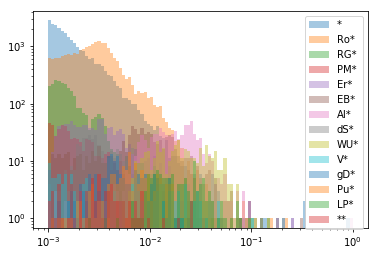

In [536]:
df = base_qs['Q4'].data
bins = np.logspace(-3,0,100)
for cl in simbad_summary[simbad_summary.ctlg_ct>100].sort_values('ctlg_ct',ascending=False).index:
    plt.hist(df[df['simbad_class']==cl].dist_score,bins=bins,log=True,alpha=0.4,label=cl)
    
plt.xscale('log')
plt.legend()

In [470]:
simbad_sampler = make_sampler(simbad_full_df.index)
simbad_sample = simbad_sampler(base_qs['Q4'].data)

In [484]:
simbad_summary

,ctlg_U_Q11out,ctlg_U_Q16out,ctlg_U_Q4out,ctlg_U_Q8out,ctlg_ct
Ce*,28,28,28,28,29
Er*,170,187,122,128,1112
Ro*,1885,1788,1450,1553,26223
Al*,737,737,732,724,794
RG*,38,41,28,32,3249
EB*,560,551,511,507,1004
PM*,51,46,18,33,1319
V*,60,58,54,58,264
dS*,91,93,76,71,463
Pu*,76,77,61,68,147


In [485]:
tmp_df = pd.DataFrame({'Mean':[simbad_sample[simbad_classes.Class==c].dist_score.mean() for c in simbad_classes.Class.unique()],
                       'Median':[simbad_sample[simbad_classes.Class==c].dist_score.median() for c in simbad_classes.Class.unique()]
                      },index=simbad_classes.Class.unique())

In [ ]:

for c in simbad_classes.Class.unique():

    subset = simbad_sample[simbad_classes.Class==c]
    mean = subset.dist_score.mean()
    med = subset.dist_score.median()
    simbad
    print("""
Class {}: Number of objects: {}, Mean outlier score: {}, Median outlier score: {}
""".format(c,len(subset),mean,med))

In [489]:
simbad_classes.Q4_mean = tmp_df.Mean

In [492]:
simbad_summary.Q4_mean = tmp_df.Mean

In [498]:
simbad_summary['Q4_median'] = tmp_df.Median

In [504]:
tmp_df.loc['*'].arb = 'a float'

In [506]:
tmp_df.loc['*'].arb

AttributeError: 'Series' object has no attribute 'arb'